## Import libraries and settings

In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# import relevant libraries
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
# set python settings
# display all rows
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Create dataframes
#### Create contributions dataframe

In [4]:
# import data - contributions
contributions = pd.read_csv('/content/drive/MyDrive/M.L. Final Project/Data/contributions_with_ward_data.csv')
contributions.drop(['Unnamed: 0'], axis=1, inplace=True)
contributions.fillna('UNKNOWN', inplace=True)
contributions.RECIPIENT = np.where(contributions['RECIPIENT'] == 'N?A', 'UNKNOWN', contributions['RECIPIENT'])
contributions = contributions[contributions.Ward != 0]
contributions['YYYY'] = contributions['PERIOD_START'].str[-4:]
contributions['YYYY'] = contributions['YYYY'].astype(int)
contributions['MM']= contributions['PERIOD_START'].str[:2]
contributions = contributions[contributions['YYYY'] >= 2019]
contributions.head()

,CONTRIBUTION_ID,PERIOD_START,PERIOD_END,CONTRIBUTION_DATE,RECIPIENT,AMOUNT,LOBBYIST_ID,LOBBYIST_FIRST_NAME,LOBBYIST_LAST_NAME,CREATED_DATE,Ward,ID,YYYY,MM
0,2240204276,07/01/2020,09/30/2020,08/24/2020,ALDERMAN MARIA HADDEN,250.0,23981,ALEXANDRA,SIMS,12/01/2020,49,95040,2020,07
1,16680854,04/01/2020,06/30/2020,06/10/2020,24TH WARD ORGANIZATION - ALD. MICHAEL SCOTT,500.0,16501,REYAHD,KAZMI,12/10/2020,24,264924,2020,04
2,146026078,01/01/2020,03/31/2020,02/18/2020,ALD. GILBERT VILLEGAS,150.0,16501,REYAHD,KAZMI,12/10/2020,36,70359,2020,01
5,752575625,10/01/2020,12/31/2020,10/19/2020,JASON ERVIN,500.0,18121,PETER,SKOSEY,12/18/2020,28,308183,2020,10
7,399395029,07/01/2020,09/30/2020,09/03/2020,VILLEGAS FOR COMMITTEEPERSON,1500.0,4126,MICHAEL,ALVAREZ,12/20/2020,36,70359,2020,07


In [5]:
# dates of interest
print('Date period start:')
print(contributions['YYYY'].min())
print('Date period end:')
print(contributions['YYYY'].max())

Date period start:
2019
Date period end:
2021


In [6]:
# how many wards are there
len(contributions['Ward'].unique())

47

In [7]:
# check which wards are missing
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

all_wards = list(range(1,51))
contr_wards = list(contributions['Ward'].unique())

print('The wards missing from the contributions data are:', Diff(all_wards, contr_wards))

The wards missing from the contributions data are: [14, 33, 35]


In [8]:
# create dataframe of average contribution
avg_amount_df = contributions.groupby(['Ward']).mean()
avg_amount_df.drop(['CONTRIBUTION_ID', 'LOBBYIST_ID', 'YYYY'], axis=1, inplace=True)
avg_amount_df.rename(columns={'AMOUNT': 'Average Contribution'}, inplace=True)
avg_amount_df.head()

,Average Contribution
Ward,
1,300.000000
2,707.692308
3,750.000000
4,538.888889
5,500.657895


In [9]:
# create dataframe of median contribution
median_amount_df = contributions.groupby(['Ward']).median()
median_amount_df.drop(['CONTRIBUTION_ID', 'LOBBYIST_ID', 'YYYY'], axis=1, inplace=True)
median_amount_df.rename(columns={'AMOUNT': 'Median Contribution'}, inplace=True)
median_amount_df.head()

,Median Contribution
Ward,
1,250.0
2,500.0
3,625.0
4,500.0
5,500.0


In [10]:
# create dataframe of sum of contributions
total_sum_df = contributions.groupby(['Ward']).sum()
total_sum_df.drop(['CONTRIBUTION_ID', 'LOBBYIST_ID', 'YYYY'], axis=1, inplace=True)
total_sum_df.rename(columns={'AMOUNT': 'Sum of Contributions'}, inplace=True)
total_sum_df.head()

,Sum of Contributions
Ward,
1,1500.0
2,18400.0
3,9000.0
4,4850.0
5,19025.0


In [11]:
# create dataframe of number of contributions
total_count_df = contributions.groupby(['Ward']).count()
total_count_df = total_count_df[['AMOUNT']]
total_count_df.rename(columns={'AMOUNT': 'Number of Contributions'}, inplace=True)
total_count_df.head()

,Number of Contributions
Ward,
1,5
2,26
3,12
4,9
5,38


In [12]:
# combine contribution dataframes
contributions_df = total_count_df.merge(avg_amount_df, how='outer', on='Ward')
contributions_df = contributions_df.merge(total_sum_df, how='outer', on='Ward')
contributions_df = contributions_df.merge(median_amount_df, how='outer', on='Ward')
contributions_df.head()

,Number of Contributions,Average Contribution,Sum of Contributions,Median Contribution
Ward,,,,
1,5,300.000000,1500.0,250.0
2,26,707.692308,18400.0,500.0
3,12,750.000000,9000.0,625.0
4,9,538.888889,4850.0,500.0
5,38,500.657895,19025.0,500.0


#### Create crimes dataframe

In [13]:
# import data - crimes
crimes = pd.read_csv('/content/drive/MyDrive/M.L. Final Project/Data/Crimes_-_2001_to_Present.csv')
crimes = crimes[crimes['Year'] >= 2019]
crimes.drop(['Case Number', 'Block', 'IUCR', 'Location Description', 'Arrest', 'Beat', 'District',
             'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude', 
             'Location'], axis=1, inplace=True)
crimes.head()

,ID,Date,Primary Type,Description,Domestic,Ward,Year
90,12014684,03/17/2020 09:30:00 PM,THEFT,$500 AND UNDER,False,45.0,2020
183,11864018,09/24/2019 08:00:00 AM,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,False,3.0,2019
235,11859805,10/13/2019 08:30:00 PM,THEFT,RETAIL THEFT,False,26.0,2019
420,12012127,03/18/2020 02:03:00 AM,MOTOR VEHICLE THEFT,AUTOMOBILE,True,28.0,2020
446,11863808,10/05/2019 06:30:00 PM,THEFT,OVER $500,False,27.0,2019


In [14]:
# dates of interest
print('Date period start:')
print(crimes['Date'].min())
print('Date period end:')
print(crimes['Date'].max())

Date period start:
01/01/2019 01:00:00 AM
Date period end:
12/31/2020 12:55:00 AM


In [15]:
# check for na in crimes
crimes.isnull().sum()

ID               0
Date             0
Primary Type     0
Description      0
Domestic         0
Ward            26
Year             0
dtype: int64

In [16]:
# drop rows with unknown Ward
crimes.dropna(inplace = True)

In [17]:
# check the number of wards
len(crimes['Ward'].unique())

50

In [18]:
# convert Ward to integer
crimes['Ward'] = crimes['Ward'].astype(int)

In [19]:
# create dataframe of total count of crimes
crimes_cnt = crimes.groupby(['Ward']).count()
crimes_cnt.drop(['Date', 'Primary Type', 'Description', 'Domestic', 'Year'], axis=1, inplace=True)
crimes_cnt.rename(columns={'ID': 'Total Count of Crimes'}, inplace=True)
crimes_cnt.head()

,Total Count of Crimes
Ward,
1,9057
2,9345
3,15238
4,13891
5,12597


In [20]:
# create dataframe of count of crimes by type
crimes_type_cnt = crimes.groupby(['Ward', 'Primary Type']).count()
crimes_type_cnt.reset_index(inplace=True)
crimes_type_cnt.drop(['Date', 'Description', 'Domestic', 'Year'], axis=1, inplace=True)
crimes_type_cnt.rename(columns={'ID':'Count of Crime'}, inplace=True)
crimes_type_cnt = crimes_type_cnt.pivot(index='Ward', columns='Primary Type', values='Count of Crime').reset_index()
crimes_type_cnt.columns.name=None
crimes_type_cnt.set_index('Ward', inplace=True)
crimes_type_cnt.head()

,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,HOMICIDE,HUMAN TRAFFICKING,INTERFERENCE WITH PUBLIC OFFICER,INTIMIDATION,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Ward,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,13.0,582.0,1215.0,444.0,2.0,15.0,926.0,37.0,200.0,884.0,1.0,14.0,NaN,12.0,7.0,2.0,17.0,338.0,97.0,NaN,4.0,46.0,NaN,404.0,5.0,1.0,38.0,NaN,330.0,43.0,13.0,3264.0,103.0
2,5.0,491.0,1000.0,383.0,2.0,16.0,614.0,49.0,274.0,1259.0,NaN,4.0,1.0,15.0,10.0,3.0,14.0,340.0,71.0,NaN,2.0,21.0,NaN,306.0,1.0,NaN,38.0,NaN,382.0,55.0,10.0,3897.0,82.0
3,32.0,1444.0,3259.0,372.0,5.0,24.0,1603.0,62.0,355.0,1280.0,2.0,41.0,1.0,89.0,6.0,13.0,14.0,735.0,578.0,NaN,8.0,116.0,3.0,1163.0,20.0,2.0,109.0,NaN,511.0,67.0,16.0,2835.0,473.0
4,9.0,1223.0,2553.0,349.0,4.0,24.0,1269.0,56.0,416.0,1257.0,NaN,16.0,NaN,45.0,9.0,7.0,2.0,572.0,244.0,NaN,5.0,98.0,NaN,867.0,NaN,NaN,111.0,NaN,563.0,59.0,21.0,3836.0,276.0
5,13.0,1141.0,2633.0,603.0,5.0,29.0,1507.0,73.0,223.0,902.0,1.0,36.0,1.0,49.0,8.0,8.0,NaN,529.0,267.0,1.0,5.0,113.0,NaN,884.0,NaN,NaN,57.0,NaN,508.0,62.0,24.0,2523.0,392.0


In [21]:
# check for missing values
crimes_type_cnt.isnull().sum()

ARSON                                 0
ASSAULT                               0
BATTERY                               0
BURGLARY                              0
CONCEALED CARRY LICENSE VIOLATION     5
CRIM SEXUAL ASSAULT                   0
CRIMINAL DAMAGE                       0
CRIMINAL SEXUAL ASSAULT               0
CRIMINAL TRESPASS                     0
DECEPTIVE PRACTICE                    0
GAMBLING                             21
HOMICIDE                              0
HUMAN TRAFFICKING                    34
INTERFERENCE WITH PUBLIC OFFICER      0
INTIMIDATION                          0
KIDNAPPING                            1
LIQUOR LAW VIOLATION                  3
MOTOR VEHICLE THEFT                   0
NARCOTICS                             0
NON-CRIMINAL                         45
OBSCENITY                             4
OFFENSE INVOLVING CHILDREN            0
OTHER NARCOTIC VIOLATION             41
OTHER OFFENSE                         0
PROSTITUTION                         15


In [22]:
# fill na with 0
crimes_type_cnt.fillna(0, inplace=True)

In [23]:
# combine crimes dataframes
crimes_df = crimes_cnt.merge(crimes_type_cnt, how='inner', on='Ward')
crimes_df.head()

,Total Count of Crimes,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,HOMICIDE,HUMAN TRAFFICKING,INTERFERENCE WITH PUBLIC OFFICER,INTIMIDATION,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Ward,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9057,13.0,582.0,1215.0,444.0,2.0,15.0,926.0,37.0,200.0,884.0,1.0,14.0,0.0,12.0,7.0,2.0,17.0,338.0,97.0,0.0,4.0,46.0,0.0,404.0,5.0,1.0,38.0,0.0,330.0,43.0,13.0,3264.0,103.0
2,9345,5.0,491.0,1000.0,383.0,2.0,16.0,614.0,49.0,274.0,1259.0,0.0,4.0,1.0,15.0,10.0,3.0,14.0,340.0,71.0,0.0,2.0,21.0,0.0,306.0,1.0,0.0,38.0,0.0,382.0,55.0,10.0,3897.0,82.0
3,15238,32.0,1444.0,3259.0,372.0,5.0,24.0,1603.0,62.0,355.0,1280.0,2.0,41.0,1.0,89.0,6.0,13.0,14.0,735.0,578.0,0.0,8.0,116.0,3.0,1163.0,20.0,2.0,109.0,0.0,511.0,67.0,16.0,2835.0,473.0
4,13891,9.0,1223.0,2553.0,349.0,4.0,24.0,1269.0,56.0,416.0,1257.0,0.0,16.0,0.0,45.0,9.0,7.0,2.0,572.0,244.0,0.0,5.0,98.0,0.0,867.0,0.0,0.0,111.0,0.0,563.0,59.0,21.0,3836.0,276.0
5,12597,13.0,1141.0,2633.0,603.0,5.0,29.0,1507.0,73.0,223.0,902.0,1.0,36.0,1.0,49.0,8.0,8.0,0.0,529.0,267.0,1.0,5.0,113.0,0.0,884.0,0.0,0.0,57.0,0.0,508.0,62.0,24.0,2523.0,392.0


#### Create business license dataframe

In [24]:
# import data - business licenses
business1 = pd.read_csv('/content/drive/MyDrive/M.L. Final Project/Data/Business_Licenses_-_Current_Active.csv')
business1 = business1[business1.CITY == 'CHICAGO']
business1 = business1[business1['LICENSE TERM START DATE'] >= '01/01/2019']
business = business1.drop(['LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'LEGAL NAME', 'DOING BUSINESS AS NAME', 'ADDRESS', 
               'CITY', 'STATE', 'ZIP CODE', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT', 'BUSINESS ACTIVITY ID', 
               'BUSINESS ACTIVITY', 'LICENSE NUMBER', 'APPLICATION TYPE', 'APPLICATION CREATED DATE', 
               'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE', 'CONDITIONAL APPROVAL', 'LICENSE APPROVED FOR ISSUANCE',
               'DATE ISSUED', 'LICENSE STATUS', 'LICENSE STATUS CHANGE DATE', 'SSA', 'LATITUDE', 'LONGITUDE', 'LOCATION', 
               'LICENSE CODE', 'LICENSE TERM EXPIRATION DATE'], axis=1)

business.head()

,ID,WARD,LICENSE DESCRIPTION,LICENSE TERM START DATE
0,2753996-20201119,42.0,Raffles,11/19/2020
1,2704238-20200516,29.0,Raffles,05/16/2020
7,2712490-20200428,46.0,Tobacco,04/28/2020
13,2398363-20190516,1.0,Regulated Business License,05/16/2019
14,2184753-20190516,33.0,Animal Care License,05/16/2019


In [25]:
# dates of interest
print('Date period start:')
print(business['LICENSE TERM START DATE'].min())
print('Date period end:')
print(business['LICENSE TERM START DATE'].max())

Date period start:
01/02/2019
Date period end:
12/31/2020


In [26]:
# check for na in business licenses 
business.isnull().sum()

ID                          0
WARD                       89
LICENSE DESCRIPTION         0
LICENSE TERM START DATE     0
dtype: int64

In [27]:
# drop rows with unknown Ward
business.dropna(inplace = True)

In [28]:
# convert Ward to integer
business['WARD'] = business['WARD'].astype(int)
business.rename(columns={'WARD':'Ward'}, inplace=True)

In [29]:
# create dataframe of total count of business licenses
business_cnt = business.groupby(['Ward']).count()
business_cnt.drop(['ID'], axis=1, inplace=True)
business_cnt.rename(columns={'LICENSE DESCRIPTION': 'Total Count of Business Licenses'}, inplace=True)
business_cnt.head()

,Total Count of Business Licenses,LICENSE TERM START DATE
Ward,,
1,1876,1876
2,2299,2299
3,1165,1165
4,1358,1358
5,756,756


In [30]:
# create dataframe of count of business licenses by type
business_type_cnt = business.groupby(['Ward', 'LICENSE DESCRIPTION']).count()
business_type_cnt.reset_index(inplace=True)
business_type_cnt.rename(columns={'ID':'Count of Business Licenses'}, inplace=True)
business_type_cnt = business_type_cnt.pivot(index='Ward', columns='LICENSE DESCRIPTION', 
                                                    values='Count of Business Licenses').reset_index()
business_type_cnt.columns.name=None
business_type_cnt.set_index('Ward', inplace=True)
business_type_cnt.head()

,Affiliation,Animal Care License,Bicycle Messenger Service,Caterer's Liquor License,Children's Services Facility License,Commercial Garage,Commercial Passenger Vessel,Consumption on Premises - Incidental Activity,Emerging Business,Explosives,Filling Station,Food - Shared Kitchen,Food - Shared Kitchen - Supplemental,Heliports,Late Hour,License Manager,Limited Business License,Manufacturing Establishments,Mobile Food License,Motor Vehicle Services License,Music and Dance,Navy Pier Kiosk License,Not-For-Profit Club,Outdoor Patio,Package Goods,Pawnbroker,Peddler License,Pharmaceutical Representative,Pop-Up Establishment Host - Tier II,Pop-Up Establishment Host - Tier III,Pop-Up Retail User,Private Booting Registration,Public Place of Amusement,Raffles,Regulated Business License,Retail Food Establishment,Secondhand Dealer,Shared Housing Unit Operator,Shared Kitchen User,Special Event Food,Special Event Liquor,Tavern,Taxicab Two-Way Dispatch Service License,Tobacco,Valet Parking Operator,Weapons Dealer,Wholesale Food Establishment,Wrigley Field
Ward,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,22.0,1.0,15.0,27.0,NaN,NaN,174.0,NaN,1.0,8.0,1.0,3.0,NaN,9.0,NaN,525.0,9.0,2.0,24.0,4.0,NaN,NaN,46.0,47.0,3.0,17.0,28.0,NaN,NaN,1.0,NaN,56.0,10.0,217.0,457.0,7.0,6.0,26.0,NaN,4.0,56.0,NaN,64.0,3.0,NaN,3.0,NaN
2,NaN,30.0,NaN,6.0,22.0,56.0,NaN,228.0,NaN,NaN,7.0,1.0,1.0,1.0,14.0,1.0,735.0,7.0,1.0,19.0,6.0,NaN,2.0,59.0,60.0,NaN,16.0,33.0,1.0,NaN,NaN,NaN,51.0,15.0,274.0,463.0,6.0,7.0,17.0,NaN,4.0,44.0,NaN,70.0,40.0,NaN,2.0,NaN
3,NaN,5.0,NaN,6.0,27.0,13.0,1.0,58.0,NaN,NaN,15.0,1.0,1.0,NaN,NaN,NaN,340.0,6.0,NaN,18.0,NaN,NaN,NaN,16.0,18.0,2.0,41.0,18.0,NaN,NaN,1.0,NaN,24.0,7.0,237.0,215.0,1.0,3.0,17.0,NaN,NaN,15.0,NaN,49.0,7.0,NaN,3.0,NaN
4,NaN,10.0,NaN,14.0,12.0,51.0,1.0,110.0,NaN,NaN,4.0,NaN,2.0,NaN,1.0,NaN,376.0,1.0,2.0,2.0,1.0,NaN,1.0,26.0,39.0,1.0,26.0,24.0,NaN,NaN,NaN,NaN,29.0,10.0,232.0,299.0,3.0,1.0,21.0,NaN,1.0,11.0,NaN,42.0,5.0,NaN,NaN,NaN
5,NaN,3.0,NaN,4.0,16.0,15.0,1.0,34.0,NaN,5.0,8.0,NaN,NaN,2.0,1.0,NaN,194.0,2.0,NaN,5.0,2.0,NaN,1.0,9.0,13.0,1.0,29.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,158.0,184.0,2.0,NaN,12.0,NaN,NaN,7.0,NaN,29.0,NaN,NaN,1.0,NaN


In [31]:
# check for missing values
business_type_cnt.isnull().sum()

Affiliation                                      43
Animal Care License                               1
Bicycle Messenger Service                        47
Caterer's Liquor License                         16
Children's Services Facility License              0
Commercial Garage                                14
Commercial Passenger Vessel                      43
Consumption on Premises - Incidental Activity     0
Emerging Business                                48
Explosives                                       46
Filling Station                                   0
Food - Shared Kitchen                            37
Food - Shared Kitchen - Supplemental             19
Heliports                                        46
Late Hour                                        19
License Manager                                  44
Limited Business License                          0
Manufacturing Establishments                      3
Mobile Food License                              26
Motor Vehicl

In [32]:
# fill na with 0
business_type_cnt.fillna(0, inplace=True)

In [33]:
# combine business licsense dataframes
business_df = business_cnt.merge(business_type_cnt, how='inner', on='Ward')
business_df.head()

,Total Count of Business Licenses,LICENSE TERM START DATE,Affiliation,Animal Care License,Bicycle Messenger Service,Caterer's Liquor License,Children's Services Facility License,Commercial Garage,Commercial Passenger Vessel,Consumption on Premises - Incidental Activity,Emerging Business,Explosives,Filling Station,Food - Shared Kitchen,Food - Shared Kitchen - Supplemental,Heliports,Late Hour,License Manager,Limited Business License,Manufacturing Establishments,Mobile Food License,Motor Vehicle Services License,Music and Dance,Navy Pier Kiosk License,Not-For-Profit Club,Outdoor Patio,Package Goods,Pawnbroker,Peddler License,Pharmaceutical Representative,Pop-Up Establishment Host - Tier II,Pop-Up Establishment Host - Tier III,Pop-Up Retail User,Private Booting Registration,Public Place of Amusement,Raffles,Regulated Business License,Retail Food Establishment,Secondhand Dealer,Shared Housing Unit Operator,Shared Kitchen User,Special Event Food,Special Event Liquor,Tavern,Taxicab Two-Way Dispatch Service License,Tobacco,Valet Parking Operator,Weapons Dealer,Wholesale Food Establishment,Wrigley Field
Ward,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1876,1876,0.0,22.0,1.0,15.0,27.0,0.0,0.0,174.0,0.0,1.0,8.0,1.0,3.0,0.0,9.0,0.0,525.0,9.0,2.0,24.0,4.0,0.0,0.0,46.0,47.0,3.0,17.0,28.0,0.0,0.0,1.0,0.0,56.0,10.0,217.0,457.0,7.0,6.0,26.0,0.0,4.0,56.0,0.0,64.0,3.0,0.0,3.0,0.0
2,2299,2299,0.0,30.0,0.0,6.0,22.0,56.0,0.0,228.0,0.0,0.0,7.0,1.0,1.0,1.0,14.0,1.0,735.0,7.0,1.0,19.0,6.0,0.0,2.0,59.0,60.0,0.0,16.0,33.0,1.0,0.0,0.0,0.0,51.0,15.0,274.0,463.0,6.0,7.0,17.0,0.0,4.0,44.0,0.0,70.0,40.0,0.0,2.0,0.0
3,1165,1165,0.0,5.0,0.0,6.0,27.0,13.0,1.0,58.0,0.0,0.0,15.0,1.0,1.0,0.0,0.0,0.0,340.0,6.0,0.0,18.0,0.0,0.0,0.0,16.0,18.0,2.0,41.0,18.0,0.0,0.0,1.0,0.0,24.0,7.0,237.0,215.0,1.0,3.0,17.0,0.0,0.0,15.0,0.0,49.0,7.0,0.0,3.0,0.0
4,1358,1358,0.0,10.0,0.0,14.0,12.0,51.0,1.0,110.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,376.0,1.0,2.0,2.0,1.0,0.0,1.0,26.0,39.0,1.0,26.0,24.0,0.0,0.0,0.0,0.0,29.0,10.0,232.0,299.0,3.0,1.0,21.0,0.0,1.0,11.0,0.0,42.0,5.0,0.0,0.0,0.0
5,756,756,0.0,3.0,0.0,4.0,16.0,15.0,1.0,34.0,0.0,5.0,8.0,0.0,0.0,2.0,1.0,0.0,194.0,2.0,0.0,5.0,2.0,0.0,1.0,9.0,13.0,1.0,29.0,8.0,0.0,0.0,0.0,0.0,8.0,2.0,158.0,184.0,2.0,0.0,12.0,0.0,0.0,7.0,0.0,29.0,0.0,0.0,1.0,0.0


#### Create population dataframe

In [34]:
pop = pd.read_excel('/content/drive/MyDrive/M.L. Final Project/Data/Estimated Ward Populations.xlsx', skiprows=1)
pop = pop[pop['Ward'] != 'Chicago']
pop.index = pop['Ward'].astype('int')
pop = pop[['White2016', 'Black2016', 'Asian2016', 'Latino2016', 'Other2016']]
pop = pop.div(pop.sum(axis=1), axis=0) # Get percent of total by race per ward
pop.head()

,White2016,Black2016,Asian2016,Latino2016,Other2016
Ward,,,,,
1,0.503864,0.058962,0.036905,0.376608,0.023661
2,0.747049,0.058640,0.069351,0.101647,0.023313
3,0.225988,0.598072,0.111786,0.040704,0.023450
4,0.241691,0.599667,0.091333,0.038784,0.028525
5,0.236848,0.617225,0.074328,0.045595,0.026004


#### Create microlenders dataframe

In [35]:
micro = pd.read_csv('/content/drive/MyDrive/M.L. Final Project/Data/Chicago_Microlending_Institute__CMI__Microloans.csv')
micro = micro[micro['Loan Date'] >= '01/01/2019']
micro.head()

,Loan Date,Lender,Block,Street Direction,Street Name,Street Type,City,State,Zip,Ward,Industry,Latitude,Longitude,Location
0,04/24/2014,Accion,NaN,NaN,NaN,NaN,Chicago,IL,60621,NaN,Other Services,NaN,NaN,NaN
1,09/06/2013,Accion,101XX,S,S,Lafayette,Chicago,IL,60628,9.0,Construction/Repair,NaN,NaN,NaN
2,08/13/2013,CNI,108XX,S,King Drive,Avenue,Chicago,IL,60628,9.0,Food/Beverage,NaN,NaN,NaN
3,12/02/2014,Accion,148XX,,Evans,Avenue,Dolton,IL,60620,NaN,Construction/Repair,NaN,NaN,NaN
4,04/14/2014,Accion,032XX,W,71st St.,Place,Chicago,IL,60629,17.0,Day Care,NaN,NaN,NaN


In [36]:
# dates of interest
print('Date period start:')
print(micro['Loan Date'].min())
print('Date period end:')
print(micro['Loan Date'].max())

Date period start:
01/07/2015
Date period end:
12/23/2015


In [37]:
# check for na in micro
micro.isnull().sum()

Loan Date           0
Lender              0
Block               1
Street Direction    4
Street Name         3
Street Type         3
City                0
State               0
Zip                 0
Ward                4
Industry            5
Latitude            7
Longitude           7
Location            7
dtype: int64

In [38]:
# drop rows with unknown Ward
micro = micro[micro['Ward'].notna()]

In [39]:
# convert Ward to integer
micro['Ward'] = micro['Ward'].astype(int)

In [40]:
# create dataframe of total count of crimes
micro_df = micro[['Ward', 'Loan Date']]
micro_cnt = micro_df.groupby(['Ward']).count()
micro_cnt.rename(columns={'Loan Date': 'Total Count of Microlenders'}, inplace=True)
micro_cnt.head()

,Total Count of Microlenders
Ward,
1,11
2,9
3,7
4,11
5,7


#### Create final dataframe

In [41]:
final_df = contributions_df.merge(business_df, how='outer', on='Ward')
final_df = final_df.merge(crimes_df, how='outer', on='Ward')
final_df = final_df.merge(micro_cnt, how='outer', on='Ward')
final_df = final_df.merge(pop, how='outer', on='Ward')
final_df.reset_index(inplace=True)
final_df.head()

,Ward,Number of Contributions,Average Contribution,Sum of Contributions,Median Contribution,Total Count of Business Licenses,LICENSE TERM START DATE,Affiliation,Animal Care License,Bicycle Messenger Service,Caterer's Liquor License,Children's Services Facility License,Commercial Garage,Commercial Passenger Vessel,Consumption on Premises - Incidental Activity,Emerging Business,Explosives,Filling Station,Food - Shared Kitchen,Food - Shared Kitchen - Supplemental,Heliports,Late Hour,License Manager,Limited Business License,Manufacturing Establishments,Mobile Food License,Motor Vehicle Services License,Music and Dance,Navy Pier Kiosk License,Not-For-Profit Club,Outdoor Patio,Package Goods,Pawnbroker,Peddler License,Pharmaceutical Representative,Pop-Up Establishment Host - Tier II,Pop-Up Establishment Host - Tier III,Pop-Up Retail User,Private Booting Registration,Public Place of Amusement,Raffles,Regulated Business License,Retail Food Establishment,Secondhand Dealer,Shared Housing Unit Operator,Shared Kitchen User,Special Event Food,Special Event Liquor,Tavern,Taxicab Two-Way Dispatch Service License,Tobacco,Valet Parking Operator,Weapons Dealer,Wholesale Food Establishment,Wrigley Field,Total Count of Crimes,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,HOMICIDE,HUMAN TRAFFICKING,INTERFERENCE WITH PUBLIC OFFICER,INTIMIDATION,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Total Count of Microlenders,White2016,Black2016,Asian2016,Latino2016,Other2016
0,1,5.0,300.000000,1500.0,250.0,1876,1876,0.0,22.0,1.0,15.0,27.0,0.0,0.0,174.0,0.0,1.0,8.0,1.0,3.0,0.0,9.0,0.0,525.0,9.0,2.0,24.0,4.0,0.0,0.0,46.0,47.0,3.0,17.0,28.0,0.0,0.0,1.0,0.0,56.0,10.0,217.0,457.0,7.0,6.0,26.0,0.0,4.0,56.0,0.0,64.0,3.0,0.0,3.0,0.0,9057,13.0,582.0,1215.0,444.0,2.0,15.0,926.0,37.0,200.0,884.0,1.0,14.0,0.0,12.0,7.0,2.0,17.0,338.0,97.0,0.0,4.0,46.0,0.0,404.0,5.0,1.0,38.0,0.0,330.0,43.0,13.0,3264.0,103.0,11,0.503864,0.058962,0.036905,0.376608,0.023661
1,2,26.0,707.692308,18400.0,500.0,2299,2299,0.0,30.0,0.0,6.0,22.0,56.0,0.0,228.0,0.0,0.0,7.0,1.0,1.0,1.0,14.0,1.0,735.0,7.0,1.0,19.0,6.0,0.0,2.0,59.0,60.0,0.0,16.0,33.0,1.0,0.0,0.0,0.0,51.0,15.0,274.0,463.0,6.0,7.0,17.0,0.0,4.0,44.0,0.0,70.0,40.0,0.0,2.0,0.0,9345,5.0,491.0,1000.0,383.0,2.0,16.0,614.0,49.0,274.0,1259.0,0.0,4.0,1.0,15.0,10.0,3.0,14.0,340.0,71.0,0.0,2.0,21.0,0.0,306.0,1.0,0.0,38.0,0.0,382.0,55.0,10.0,3897.0,82.0,9,0.747049,0.058640,0.069351,0.101647,0.023313
2,3,12.0,750.000000,9000.0,625.0,1165,1165,0.0,5.0,0.0,6.0,27.0,13.0,1.0,58.0,0.0,0.0,15.0,1.0,1.0,0.0,0.0,0.0,340.0,6.0,0.0,18.0,0.0,0.0,0.0,16.0,18.0,2.0,41.0,18.0,0.0,0.0,1.0,0.0,24.0,7.0,237.0,215.0,1.0,3.0,17.0,0.0,0.0,15.0,0.0,49.0,7.0,0.0,3.0,0.0,15238,32.0,1444.0,3259.0,372.0,5.0,24.0,1603.0,62.0,355.0,1280.0,2.0,41.0,1.0,89.0,6.0,13.0,14.0,735.0,578.0,0.0,8.0,116.0,3.0,1163.0,20.0,2.0,109.0,0.0,511.0,67.0,16.0,2835.0,473.0,7,0.225988,0.598072,0.111786,0.040704,0.023450
3,4,9.0,538.888889,4850.0,500.0,1358,1358,0.0,10.0,0.0,14.0,12.0,51.0,1.0,110.0,0.0,0.0,4.0,0.0,2.0,0.0,1.0,0.0,376.0,1.0,2.0,2.0,1.0,0.0,1.0,26.0,39.0,1.0,26.0,24.0,0.0,0.0,0.0,0.0,29.0,10.0,232.0,299.0,3.0,1.0,21.0,0.0,1.0,11.0,0.0,42.0,5.0,0.0,0.0,0.0,13891,9.0,1223.0,2553.0,349.0,4.0,24.0,1269.0,56.0,416.0,1257.0,0.0,16.0,0.0,45.0,9.0,7.0,2.0,572.0,244.0,0.0,5.0,98.0,0.0,867.0,0.0,0.0,111.0,0.0,563.0,59.0,21.0,3836.0,276.0,11,0.241691,0.599667,0.091333,0.038784,0.028525
4,5,38.0,500.657895,19025.0,500.0,756,756,0.0,3.0,0.0,4.0,16.0,15.0,1.0,34.0,0.0,5.0,8.0,0.0,0.0,2.0,1.0,0.0,194.0,2.0,0.0,5.0,2.0,0.0,1.0,9.0,13.0,1.0,29.0,8.0,0.0,0.0,0.0,0.0,8.0,2.0,158.0,184.0,2.0,0.0,12.0,0.0,0.0,7.0,0.0,29.0,0.0,0.0,1.0,0.0,12597,13.0,1141.0,2633.0

In [42]:
# check for missing values
final_df.isnull().sum()

Ward                                             0
Number of Contributions                          3
Average Contribution                             3
Sum of Contributions                             3
Median Contribution                              3
Total Count of Business Licenses                 0
LICENSE TERM START DATE                          0
Affiliation                                      0
Animal Care License                              0
Bicycle Messenger Service                        0
Caterer's Liquor License                         0
Children's Services Facility License             0
Commercial Garage                                0
Commercial Passenger Vessel                      0
Consumption on Premises - Incidental Activity    0
Emerging Business                                0
Explosives                                       0
Filling Station                                  0
Food - Shared Kitchen                            0
Food - Shared Kitchen - Supplem

In [43]:
# fill na with 0
final_df.fillna(0, inplace=True)

In [44]:
final_df.to_csv('/content/drive/MyDrive/M.L. Final Project/Data/Data by Ward.csv')

## EDA

#### Business license dataframe

In [45]:
# find missing values
business1.isnull().sum()

ID                                       0
LICENSE ID                               0
ACCOUNT NUMBER                           0
SITE NUMBER                              0
LEGAL NAME                               0
DOING BUSINESS AS NAME                  30
ADDRESS                                  0
CITY                                     0
STATE                                    0
ZIP CODE                                54
WARD                                    89
PRECINCT                             11978
WARD PRECINCT                           82
POLICE DISTRICT                      11561
LICENSE CODE                             0
LICENSE DESCRIPTION                      0
BUSINESS ACTIVITY ID                  6456
BUSINESS ACTIVITY                     6456
LICENSE NUMBER                           0
APPLICATION TYPE                         0
APPLICATION CREATED DATE             48781
APPLICATION REQUIREMENTS COMPLETE        9
PAYMENT DATE                           267
CONDITIONAL

In [46]:
# drop rows with missing ward value
business1 = business1[business1['WARD'].notna()]
# convert ward to int type
business1.WARD = business1.WARD.astype('int')

In [47]:
# shape of df
print('Shape of busines license dataframe:', business1.shape)

Shape of busines license dataframe: (63029, 34)


In [48]:
# columns in df
business1.columns

Index(['ID', 'LICENSE ID', 'ACCOUNT NUMBER', 'SITE NUMBER', 'LEGAL NAME',
       'DOING BUSINESS AS NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP CODE',
       'WARD', 'PRECINCT', 'WARD PRECINCT', 'POLICE DISTRICT', 'LICENSE CODE',
       'LICENSE DESCRIPTION', 'BUSINESS ACTIVITY ID', 'BUSINESS ACTIVITY',
       'LICENSE NUMBER', 'APPLICATION TYPE', 'APPLICATION CREATED DATE',
       'APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE',
       'CONDITIONAL APPROVAL', 'LICENSE TERM START DATE',
       'LICENSE TERM EXPIRATION DATE', 'LICENSE APPROVED FOR ISSUANCE',
       'DATE ISSUED', 'LICENSE STATUS', 'LICENSE STATUS CHANGE DATE', 'SSA',
       'LATITUDE', 'LONGITUDE', 'LOCATION'],
      dtype='object')

In [49]:
# number of possible business licenses
len(business1['LICENSE DESCRIPTION'].unique())

48

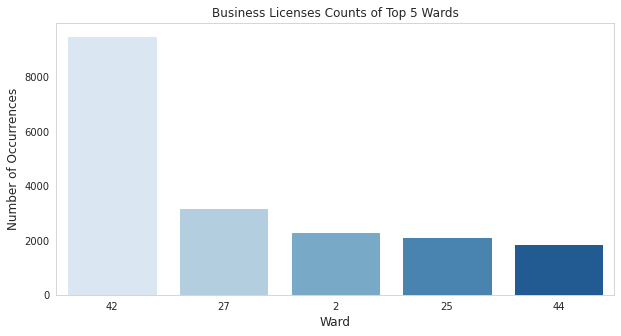

In [50]:
# plot count of licenses by ward
bus_cnts = business1['WARD'].value_counts()
bus_cnts = bus_cnts[:5]

order = list(bus_cnts.index)
plt.figure(figsize=(10,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(bus_cnts.index, bus_cnts.values, order=order, palette='Blues')
plt.title('Business Licenses Counts of Top 5 Wards')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ward', fontsize=12)
plt.show()

In [51]:
# percent of license in top five category of license type
bus_cnts = business1['WARD'].value_counts()
sum(bus_cnts[:1])/sum(bus_cnts)

0.15083532976883657

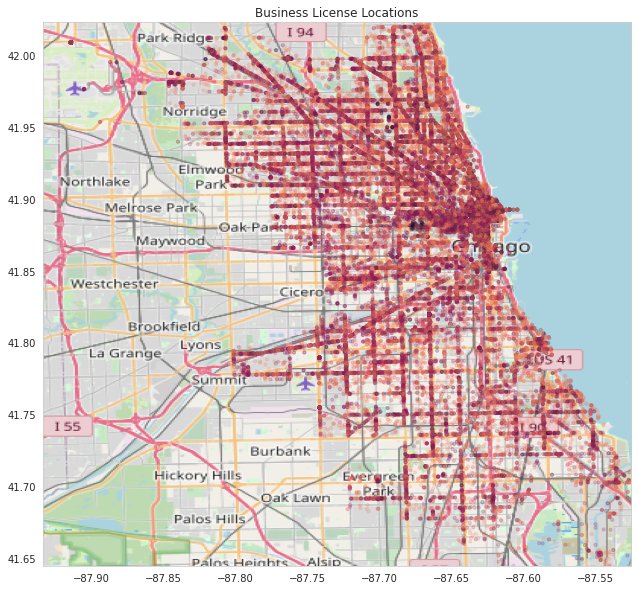

In [52]:
# create dataframe of business locations
geo_df = business1[['LATITUDE', 'LONGITUDE', 'LICENSE DESCRIPTION']]
BBox = (geo_df.LONGITUDE.min(), geo_df.LONGITUDE.max(), geo_df.LATITUDE.min(), geo_df.LATITUDE.max())
# import map of Chicago
ruh_m = plt.imread('/content/drive/MyDrive/M.L. Final Project/Data/chicago_map.png')
# plot business location
fig, ax = plt.subplots(figsize = (15,10))
categories = np.unique(geo_df['LICENSE DESCRIPTION'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  
geo_df["Color"] = geo_df['LICENSE DESCRIPTION'].apply(lambda x: colordict[x])
ax.scatter(geo_df.LONGITUDE, geo_df.LATITUDE, zorder=1, alpha= 0.2, c=geo_df.Color, s=10)
ax.set_title('Business License Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [53]:
# percent of licenses issues above latitude = 41.85
geo_df[geo_df.LATITUDE > 41.85]['LATITUDE'].count()/geo_df['LATITUDE'].count()

0.7266635373334844

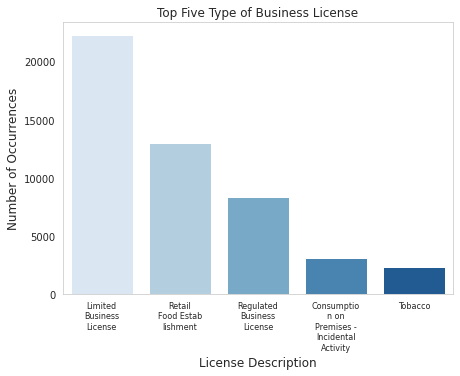

In [54]:
# plot count of licenses by ward
bus_cnts = business['LICENSE DESCRIPTION'].value_counts()
bus_cnts = bus_cnts[:5]
order = list(bus_cnts.index)
plt.figure(figsize=(7,5))
sns.barplot(bus_cnts.index, bus_cnts.values, order=order, palette='Blues')
plt.title('Top Five Type of Business License')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('License Description', fontsize=12)

x_axis=range(5)
labels = list(bus_cnts.index)
plt.xticks(x_axis, [textwrap.fill(label, 10) for label in labels], 
           fontsize=8, horizontalalignment="center")

plt.show()

In [55]:
# percent of license in top five category of license type
type_cnt = business['LICENSE DESCRIPTION'].value_counts()
sum(type_cnt[:5])/sum(type_cnt)

0.7786733091116788

Crime dataframe

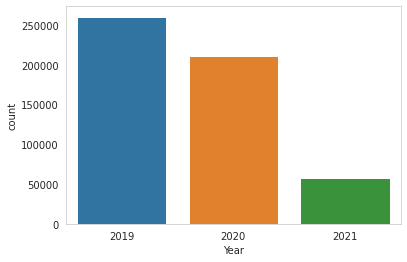

In [56]:
# count of crimes by year
ax = sns.countplot(x="Year", data=crimes)

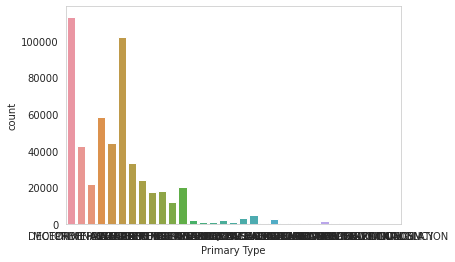

In [57]:
# crime count by type
ax = sns.countplot(x="Primary Type", data=crimes)

In [58]:
crimes['Primary Type'].unique()

array(['THEFT', 'DECEPTIVE PRACTICE', 'MOTOR VEHICLE THEFT',
       'CRIMINAL DAMAGE', 'ASSAULT', 'BATTERY', 'OTHER OFFENSE',
       'NARCOTICS', 'WEAPONS VIOLATION', 'ROBBERY', 'CRIMINAL TRESPASS',
       'BURGLARY', 'INTERFERENCE WITH PUBLIC OFFICER', 'ARSON',
       'CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'PROSTITUTION',
       'PUBLIC PEACE VIOLATION', 'OFFENSE INVOLVING CHILDREN',
       'LIQUOR LAW VIOLATION', 'SEX OFFENSE', 'STALKING', 'KIDNAPPING',
       'INTIMIDATION', 'CONCEALED CARRY LICENSE VIOLATION', 'HOMICIDE',
       'GAMBLING', 'OBSCENITY', 'HUMAN TRAFFICKING', 'NON-CRIMINAL',
       'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'RITUALISM'],
      dtype=object)

In [59]:
crimes['Primary Type'].value_counts()

THEFT                                113362
BATTERY                              102068
CRIMINAL DAMAGE                       58398
ASSAULT                               44367
DECEPTIVE PRACTICE                    42369
OTHER OFFENSE                         33332
NARCOTICS                             24101
MOTOR VEHICLE THEFT                   21789
BURGLARY                              19972
ROBBERY                               17980
WEAPONS VIOLATION                     17421
CRIMINAL TRESPASS                     11984
OFFENSE INVOLVING CHILDREN             4790
PUBLIC PEACE VIOLATION                 2950
SEX OFFENSE                            2514
INTERFERENCE WITH PUBLIC OFFICER       2307
CRIMINAL SEXUAL ASSAULT                2156
HOMICIDE                               1481
ARSON                                  1105
CRIM SEXUAL ASSAULT                    1004
PROSTITUTION                            972
STALKING                                522
CONCEALED CARRY LICENSE VIOLATIO

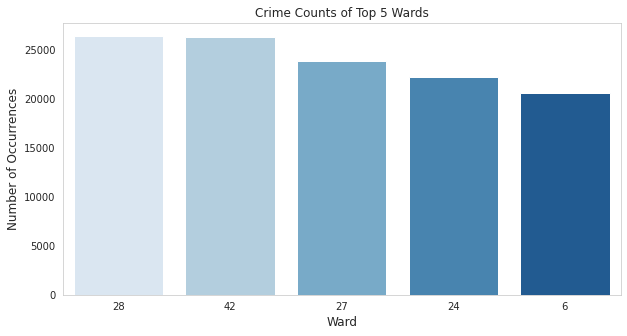

In [60]:
# plot count of licenses by ward
crime_cnts = crimes['Ward'].value_counts()
crime_cnts = crime_cnts[:5]

order = list(crime_cnts.index)
plt.figure(figsize=(10,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(crime_cnts.index, crime_cnts.values, order=order, palette='Blues')
plt.title('Crime Counts of Top 5 Wards')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ward', fontsize=12)
plt.show()

In [61]:
# percent of license in top five category of license type
crime_cnts = crimes['Ward'].value_counts()
sum(crime_cnts[1:2])/sum(crime_cnts)

0.04983709104936813

In [105]:
# top crime in ward 42
crime_42 = crimes[crimes['Ward'] == 42]
val_42 = crime_42['Primary Type'].value_counts()

Population dataframe

<Figure size 720x360 with 0 Axes>

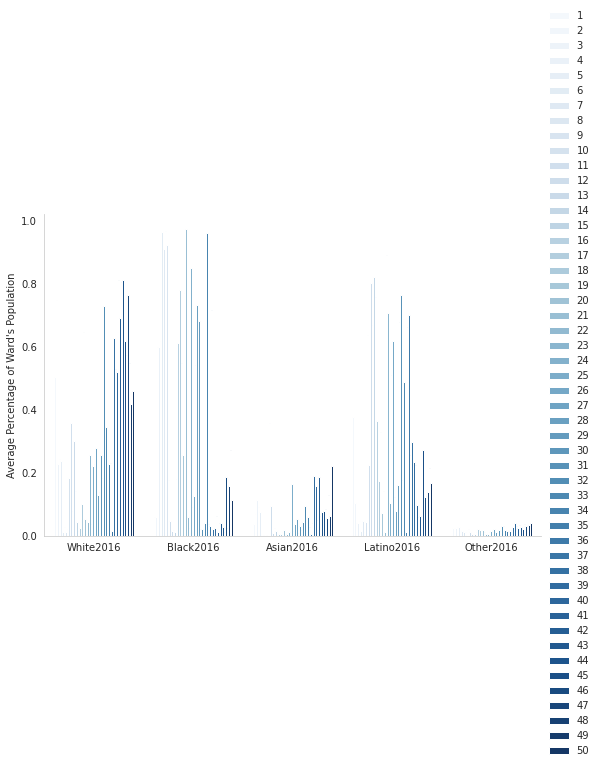

In [62]:
pop_df = pop.T.unstack().reset_index(level=1, name='Percentage').rename(columns={'level_1':'Race'})[['Race','Percentage']]
pop_df.reset_index(inplace=True)
pop_df.rename(columns={'index':'Cluster'}, inplace=True)

# plot
plt.figure(figsize=(10,5))
g = sns.catplot(data=pop_df, kind="bar", x="Race", y="Percentage", hue="Ward", palette="Blues", aspect=1.5)
g.set_axis_labels("", "Average Percentage of Ward's Population")
g.legend.set_title("")

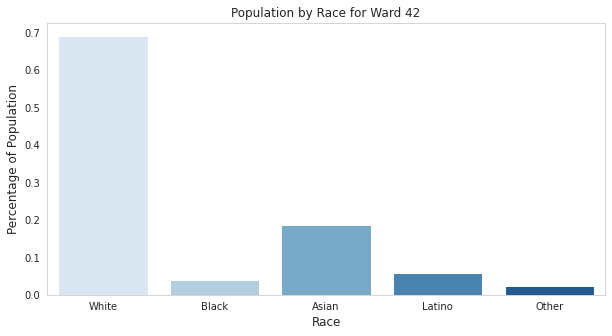

In [63]:
pop_df2 = pop_df[pop_df['Ward']==42]
pop_df2['Race'] = pop_df2['Race'].str.slice(0, -4)

# plot
order = list(pop_df2.Percentage)
plt.figure(figsize=(10,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(x = 'Race', y='Percentage', data=pop_df2, palette='Blues')
plt.title('Population by Race for Ward 42')
plt.ylabel('Percentage of Population', fontsize=12)
plt.xlabel('Race', fontsize=12)
plt.show()

Microlenders dataframe

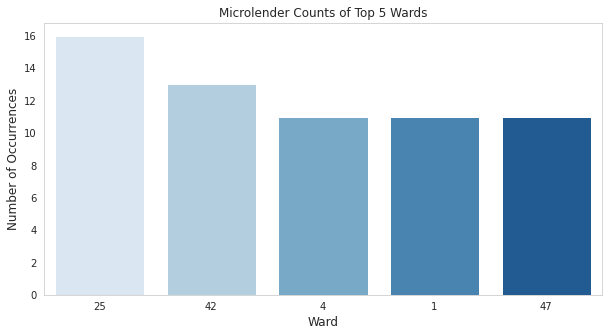

In [64]:
# plot count of microlenders by ward
micro_cnts = micro['Ward'].value_counts()
micro_cnts = micro_cnts[:5]

order = list(micro_cnts.index)
plt.figure(figsize=(10,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(micro_cnts.index, micro_cnts.values, order=order, palette='Blues')
plt.title('Microlender Counts of Top 5 Wards')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ward', fontsize=12)
plt.show()

In [65]:
# percent of microlenders in top five category 
micro_cnts = micro['Ward'].value_counts()
sum(micro_cnts[1:2])/sum(micro_cnts)

0.05263157894736842

Contributions dataframe

In [66]:
contributions.columns

Index(['CONTRIBUTION_ID', 'PERIOD_START', 'PERIOD_END', 'CONTRIBUTION_DATE',
       'RECIPIENT', 'AMOUNT', 'LOBBYIST_ID', 'LOBBYIST_FIRST_NAME',
       'LOBBYIST_LAST_NAME', 'CREATED_DATE', 'Ward', 'ID', 'YYYY', 'MM'],
      dtype='object')

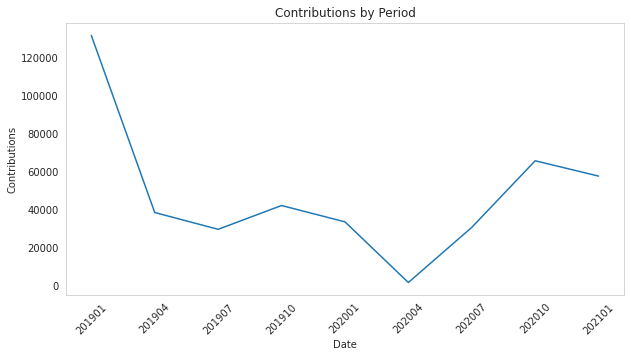

In [67]:
contributions['YYYY'] = contributions['YYYY'].astype(str)
contributions['YYYYMM'] = contributions['YYYY'] + contributions['MM']

graph_data = contributions.groupby('YYYYMM')['AMOUNT'].sum()
graph_data.sort_index(inplace=True)
graph_data

plt.figure(figsize=(10,5))
g = sns.lineplot(x = graph_data.index, y = graph_data)
g = g.set(title = "Contributions by Period", xlabel = "Date", ylabel = "Contributions")
plt.xticks(rotation=45)
plt.show()

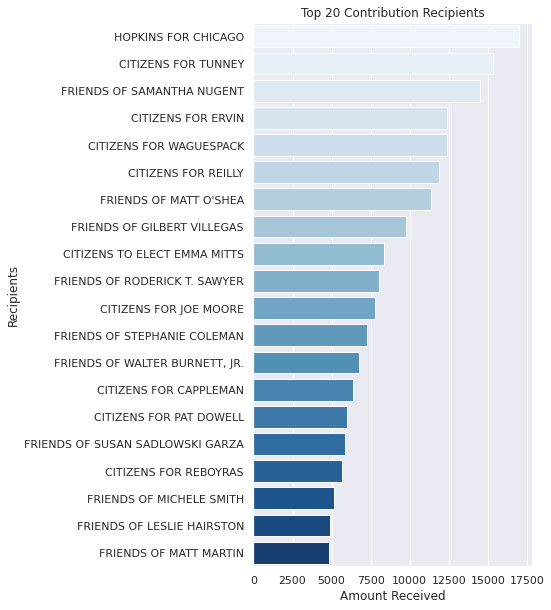

In [68]:
graph_data = contributions.groupby('RECIPIENT')['AMOUNT'].sum().sort_values(ascending = False)[0:20]

sns.set(rc={'figure.figsize':(5, 10)})
g = sns.barplot(y = graph_data.index, x = graph_data, palette="Blues")
g = g.set(title = "Top 20 Contribution Recipients", xlabel = "Amount Received", ylabel = "Recipients")

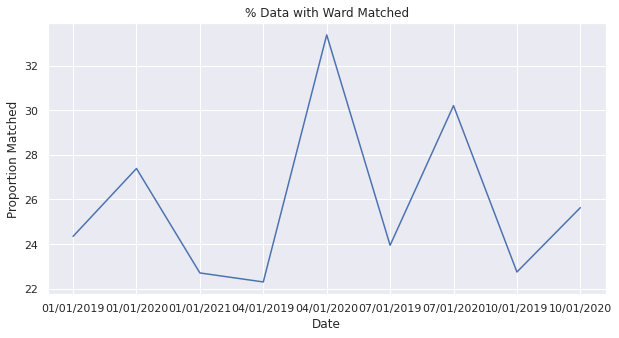

In [69]:
graph_data = contributions.groupby('PERIOD_START')['Ward'].mean()

plt.figure(figsize=(10,5))
g = sns.lineplot(x = graph_data.index, y = graph_data)
g = g.set(title = "% Data with Ward Matched", xlabel = "Date", ylabel = "Proportion Matched")

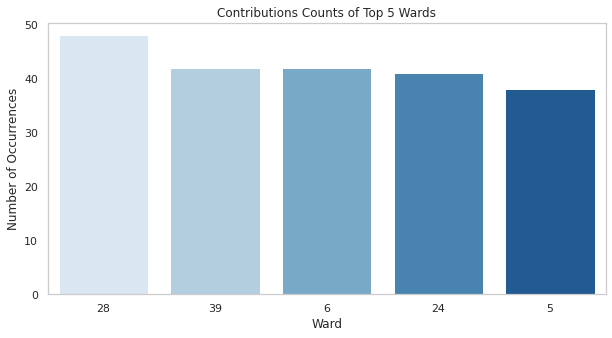

In [70]:
# plot contributions by ward
contributions_cnts = contributions['Ward'].value_counts()
contributions_cnts = contributions_cnts[:5]

contributions_cnts

order = list(contributions_cnts.index)
plt.figure(figsize=(10,5))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(contributions_cnts.index, contributions_cnts.values, palette='Blues', order=order)
plt.title('Contributions Counts of Top 5 Wards')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Ward', fontsize=12)
plt.show()

In [71]:
# ward ranked by contribution
contributions['Ward'].value_counts()

28    48
39    42
6     42
24    41
5     38
36    35
22    33
44    30
17    26
27    26
2     26
21    25
15    23
47    23
16    22
19    22
37    22
42    22
10    19
32    17
43    17
31    16
12    15
30    14
9     12
50    12
3     12
46    12
8      9
34     9
40     9
4      9
11     9
20     7
26     6
1      5
49     5
41     5
48     5
29     4
18     3
23     3
13     2
7      2
38     2
45     2
25     2
Name: Ward, dtype: int64

#### Final dataframe

In [72]:
# shape of final df
print('Final df shape:', final_df.shape)

Final df shape: (50, 95)


In [73]:
# Examine the top 5 & bottom 5 wards by crime
top_5 = final_df[['Total Count of Crimes','Ward']]
top_5 = top_5.groupby('Ward').mean()
top_5 = top_5.sort_values('Total Count of Crimes', ascending = False)
print('\nTop 5 Neighborhoods:\n= = = = = = = = = = = = =')
print(top_5.head(5))
print('\nBottom 5 Neighborhoods:\n= = = = = = = = = = = = =')
print(top_5.tail(5))


Top 5 Neighborhoods:
= = = = = = = = = = = = =
      Total Count of Crimes
Ward                       
28                    26464
42                    26355
27                    23929
24                    22247
6                     20584

Bottom 5 Neighborhoods:
= = = = = = = = = = = = =
      Total Count of Crimes
Ward                       
33                     4955
39                     4859
13                     4690
19                     4500
38                     4216


In [74]:
# Examine the top 5 & bottom 5 wards by business license
top_5 = final_df[['Total Count of Business Licenses','Ward']]
top_5 = top_5.groupby('Ward').mean()
top_5 = top_5.sort_values('Total Count of Business Licenses', ascending = False)
print('\nTop 5 Neighborhoods:\n= = = = = = = = = = = = =')
print(top_5.head(5))
print('\nBottom 5 Neighborhoods:\n= = = = = = = = = = = = =')
print(top_5.tail(5))


Top 5 Neighborhoods:
= = = = = = = = = = = = =
      Total Count of Business Licenses
Ward                                  
42                                9507
27                                3189
2                                 2299
25                                2116
44                                1877

Bottom 5 Neighborhoods:
= = = = = = = = = = = = =
      Total Count of Business Licenses
Ward                                  
9                                  549
24                                 536
13                                 520
34                                 508
7                                  444


In [75]:
# Examine the top 5 & bottom 5 wards by contribution
top_5 = final_df[['Number of Contributions','Ward']]
top_5 = top_5.groupby('Ward').mean()
top_5 = top_5.sort_values('Number of Contributions', ascending = False)
print('\nTop 5 Neighborhoods:\n= = = = = = = = = = = = =')
print(top_5.head(5))
print('\nBottom 5 Neighborhoods:\n= = = = = = = = = = = = =')
print(top_5.tail(5))


Top 5 Neighborhoods:
= = = = = = = = = = = = =
      Number of Contributions
Ward                         
28                       48.0
6                        42.0
39                       42.0
24                       41.0
5                        38.0

Bottom 5 Neighborhoods:
= = = = = = = = = = = = =
      Number of Contributions
Ward                         
13                        2.0
7                         2.0
35                        0.0
33                        0.0
14                        0.0


Text(0.5, 0, 'Contribution Count')

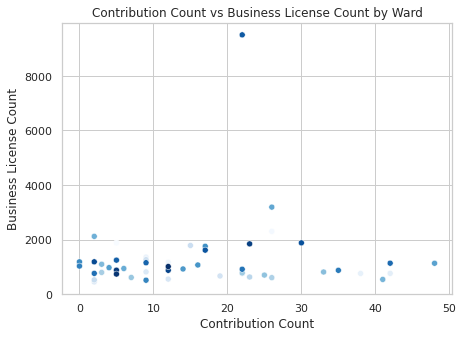

In [110]:
# scatter plot total contributions vs total business licenses
plt.figure(figsize=(7,5))
sns.scatterplot(data=final_df, x="Number of Contributions", y="Total Count of Business Licenses", palette='Blues', hue='Ward', legend=False)
#plt.ylim(0,2000) 
plt.title('Contribution Count vs Business License Count by Ward')
plt.ylabel('Business License Count', fontsize=12)
plt.xlabel('Contribution Count', fontsize=12)

Text(0.5, 0, 'Contribution Count')

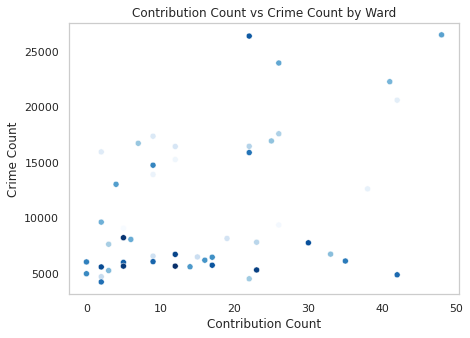

In [77]:
# scatter plot total contributions vs total crime
plt.figure(figsize=(7,5))
sns.scatterplot(data=final_df, x="Number of Contributions", y="Total Count of Crimes", palette='Blues', hue='Ward', legend=False)
plt.title('Contribution Count vs Crime Count by Ward')
plt.ylabel('Crime Count', fontsize=12)
plt.xlabel('Contribution Count', fontsize=12)

Text(0.5, 0, 'Contribution Count')

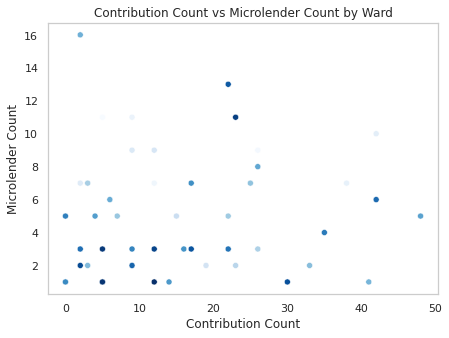

In [78]:
# scatter plot total contributions vs total crime
plt.figure(figsize=(7,5))
sns.scatterplot(data=final_df, x="Number of Contributions", y="Total Count of Microlenders", palette='Blues', hue='Ward', legend=False)
plt.title('Contribution Count vs Microlender Count by Ward')
plt.ylabel('Microlender Count', fontsize=12)
plt.xlabel('Contribution Count', fontsize=12)

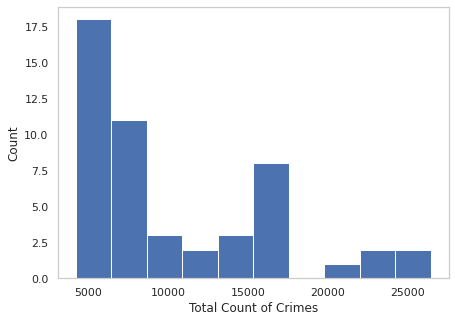

In [79]:
# histogram crime
plt.figure(figsize=(7,5))
plt.hist(final_df['Total Count of Crimes'])
plt.xlabel('Total Count of Crimes')
plt.ylabel('Count')
plt.show()

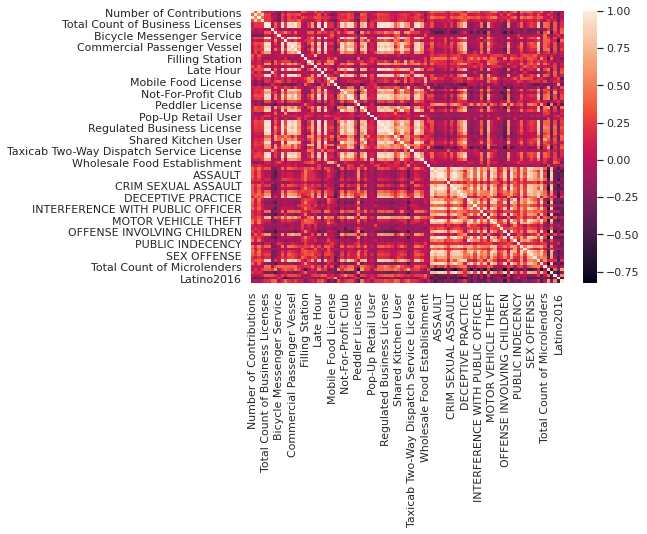

In [80]:
# correlation heatmap
plt.figure(figsize=(7,5))
sns.heatmap(final_df.drop(['Ward'], axis=1).corr())

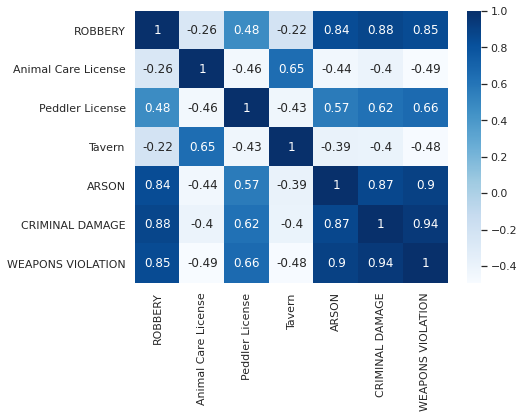

In [81]:
plt.figure(figsize=(7,5))
sns.heatmap(final_df[['ROBBERY', 'Animal Care License', 'Peddler License', 'Tavern', 'ARSON', 'CRIMINAL DAMAGE', 'WEAPONS VIOLATION']].corr(), 
            annot=True, 
            cmap="Blues")

In [82]:
corr = final_df.drop(['Ward'], axis=1).corr()
corr

,Number of Contributions,Average Contribution,Sum of Contributions,Median Contribution,Total Count of Business Licenses,LICENSE TERM START DATE,Affiliation,Animal Care License,Bicycle Messenger Service,Caterer's Liquor License,Children's Services Facility License,Commercial Garage,Commercial Passenger Vessel,Consumption on Premises - Incidental Activity,Emerging Business,Explosives,Filling Station,Food - Shared Kitchen,Food - Shared Kitchen - Supplemental,Heliports,Late Hour,License Manager,Limited Business License,Manufacturing Establishments,Mobile Food License,Motor Vehicle Services License,Music and Dance,Navy Pier Kiosk License,Not-For-Profit Club,Outdoor Patio,Package Goods,Pawnbroker,Peddler License,Pharmaceutical Representative,Pop-Up Establishment Host - Tier II,Pop-Up Establishment Host - Tier III,Pop-Up Retail User,Private Booting Registration,Public Place of Amusement,Raffles,Regulated Business License,Retail Food Establishment,Secondhand Dealer,Shared Housing Unit Operator,Shared Kitchen User,Special Event Food,Special Event Liquor,Tavern,Taxicab Two-Way Dispatch Service License,Tobacco,Valet Parking Operator,Weapons Dealer,Wholesale Food Establishment,Wrigley Field,Total Count of Crimes,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,GAMBLING,HOMICIDE,HUMAN TRAFFICKING,INTERFERENCE WITH PUBLIC OFFICER,INTIMIDATION,KIDNAPPING,LIQUOR LAW VIOLATION,MOTOR VEHICLE THEFT,NARCOTICS,NON-CRIMINAL,OBSCENITY,OFFENSE INVOLVING CHILDREN,OTHER NARCOTIC VIOLATION,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,Total Count of Microlenders,White2016,Black2016,Asian2016,Latino2016,Other2016
Number of Contributions,1.000000,0.389882,0.945355,0.303310,0.079800,0.079800,0.131400,-0.072978,-0.226605,0.081258,-0.007482,0.121069,0.018394,0.062296,-0.060673,0.356740,0.281848,0.110902,0.061250,0.347112,0.120490,2.688619e-01,0.066183,0.153189,-0.013384,0.014961,0.119644,0.069281,0.064227,0.131585,0.113496,-0.129252,0.078643,0.100674,0.156506,0.080455,0.008879,-8.869376e-03,0.095069,0.082720,0.076243,0.068643,0.018213,-0.027183,0.025575,0.069281,0.094876,0.024818,0.168636,0.159447,0.107965,0.043110,-0.095056,0.158676,0.420357,0.385352,0.349344,0.393181,0.262638,0.108626,0.370723,0.337664,0.369915,0.326036,0.151242,0.456143,0.397374,0.336355,0.403642,0.160849,0.228185,0.216271,0.430157,0.513245,0.197614,0.060680,0.254382,-0.034051,0.305399,0.472124,0.018160,0.479232,0.359814,0.477295,0.383530,0.229101,0.223218,0.430035,0.071414,-0.084177,0.232916,-0.074364,-0.198502,-0.082594
Average Contribution,0.389882,1.000000,0.567513,0.869784,0.233654,0.233654,-0.112371,-0.061000,-0.311576,0.295144,0.100830,0.327050,0.237195,0.272342,0.311986,0.039632,0.023270,0.064240,0.032776,0.114813,0.325212,-9.772599e-02,0.220116,0.004098,-0.228643,-0.267019,0.141748,0.234387,0.213853,0.320085,0.222784,-0.170153,-0.220836,0.373430,0.321901,-0.116812,0.066811,1.428519e-01,0.305863,0.261844,0.253403,0.210454,0.086629,0.080152,0.168405,0.234387,0.255996,0.181786,0.072374,0.193130,0.305976,0.164602,-0.231238,0.098749,0.243461,0.120439,0.126229,0.132330,0.134339,0.059892,0.191207,0.117404,0.148176,0.330825,0.392882,0.088501,0.067847,0.096689,0.177079,0.086252,0.084420,0.202332,0.199928,0.143602,-0.040335,0.224900,-0.003226,0.354783,0.140975,0.059784,-0.155705,0.187356,0.056951,0.164935,0.235609,0.056430,0.324983,0.086473,-0.017883,0.223270,0.103255,0.012272,-0.356133,0.072381
Sum of Contributions,0.945355,0.567513,1.000000,0.447885,0.219555,0.219555,0.060110,-0.023167,-0.253677,0.233046,0.007767,0.280417,0.130720,0.216912,0.036337,0.319904,0.211748,0.141387,0.141539,0.338077,0.292684,1.956612e-01,0.190852,0.190990,-0.002799,-0.058928,0.191620,0.186485,0.147604,0.297458,0.253167,-0.093505,0.016490,0.260893,0.301216,-0.033008,0.030184,-1.457455e-02,0.257234,0.218132,0.221499,0.2

In [83]:
ward42 = contributions[contributions['Ward']==42]

ward42.describe()

,CONTRIBUTION_ID,AMOUNT,LOBBYIST_ID,Ward
count,2.200000e+01,22.000000,22.000000,22.0
mean,2.298090e+09,836.363636,9240.090909,42.0
std,1.202277e+09,495.979507,6916.489213,0.0
min,4.377102e+08,100.000000,3740.000000,42.0
25%,1.266462e+09,500.000000,4162.000000,42.0
50%,2.289044e+09,750.000000,4660.000000,42.0
75%,3.322765e+09,1375.000000,15356.000000,42.0
max,4.168703e+09,1500.000000,24803.000000,42.0


## Create models
#### K-means

In [84]:
# create target and predictor dataframes
contributions_df = final_df[['Ward', 'Number of Contributions', 'Average Contribution', 'Sum of Contributions', 'Median Contribution']]
reduced_df = final_df.drop(['Ward', 'Number of Contributions', 'Average Contribution', 'Sum of Contributions', 'Median Contribution'], axis=1)

In [85]:
# scale the predictor data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(reduced_df)

In [86]:
# perform PCA
pca = PCA(n_components=0.95)
pca_df = pca.fit_transform(scaled_df)

print('Predictor data shape:', reduced_df.shape)
print('PCA data shape:', pca_df.shape)

Predictor data shape: (50, 90)
PCA data shape: (50, 21)


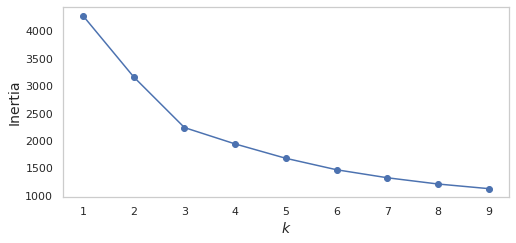

In [87]:
# elbow method to calculate number of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(pca_df) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

# plot data
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [88]:
# create kmeans model and y_pred 
kmeans = KMeans(n_clusters=3, random_state=42)
y_pred = kmeans.fit_predict(pca_df)

In [89]:
# how many wards in each cluster
np.unique(y_pred, return_counts=True)

(array([0, 1, 2], dtype=int32), array([17,  1, 32]))

In [90]:
# compare cluster predictions to target dataframe
contributions_df['cluster'] = y_pred

contributions_df

,Ward,Number of Contributions,Average Contribution,Sum of Contributions,Median Contribution,cluster
0,1,5.0,300.000000,1500.0,250.0,2
1,2,26.0,707.692308,18400.0,500.0,2
2,3,12.0,750.000000,9000.0,625.0,0
3,4,9.0,538.888889,4850.0,500.0,0
4,5,38.0,500.657895,19025.0,500.0,0
5,6,42.0,445.238095,18700.0,500.0,0
6,7,2.0,275.000000,550.0,275.0,0
7,8,9.0,380.555556,3425.0,500.0,0
8,9,12.0,775.000000,9300.0,500.0,0
9,10,19.0,564.210526,10720.0,500.0,2


In [91]:
# average target values by cluster
average_contributions_df = contributions_df.groupby(['cluster']).mean()
average_contributions_df.reset_index(inplace=True)
average_contributions_df['cluster'] = average_contributions_df['cluster'].astype(str)
average_contributions_df

,cluster,Ward,Number of Contributions,Average Contribution,Sum of Contributions,Median Contribution
0,0,17.352941,20.823529,531.131855,11443.529412,414.705882
1,1,42.000000,22.000000,836.363636,18400.000000,750.000000
2,2,29.312500,12.937500,440.784999,6875.531250,366.796875


In [92]:
# look at clusters by predictor values
reduced_df['cluster'] = y_pred
average_reduced_df = reduced_df.groupby(['cluster']).mean()
average_reduced_df.reset_index(inplace=True)
average_reduced_df['cluster'] = average_reduced_df['cluster'].astype(str)
average_reduced_df.T

,0,1,2
cluster,0,1,2
Total Count of Business Licenses,926.706,9507,1180.25
LICENSE TERM START DATE,926.706,9507,1180.25
Affiliation,0,0,0.46875
Animal Care License,4.17647,12,10.3438
Bicycle Messenger Service,0,0,0.09375
Caterer's Liquor License,3.94118,96,2.46875
Children's Services Facility License,20.5882,25,18.7188
Commercial Garage,12,239,7.59375
Commercial Passenger Vessel,0.176471,6,0.09375


Text(0.5, 0, 'Cluster')

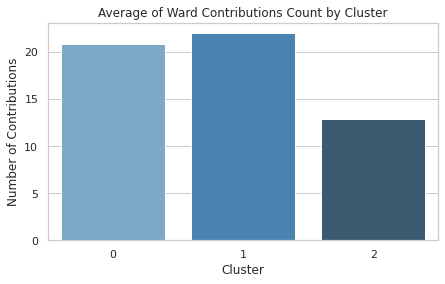

In [93]:
# view average number of contributions per ward by cluster
plt.figure(figsize=(7,4))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Number of Contributions', data=average_contributions_df, palette="Blues_d")
plt.title('Average of Ward Contributions Count by Cluster')
plt.ylabel('Number of Contributions', fontsize=12)
plt.xlabel('Cluster', fontsize=12)

Text(0.5, 0, 'Cluster')

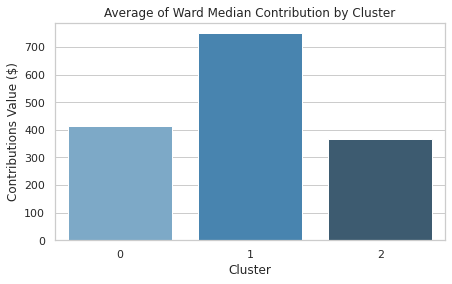

In [94]:
# view average median contribution per ward by cluster
plt.figure(figsize=(7,4))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Median Contribution', data=average_contributions_df, palette="Blues_d")
plt.title('Average of Ward Median Contribution by Cluster')
plt.ylabel('Contributions Value ($)', fontsize=12)
plt.xlabel('Cluster', fontsize=12)

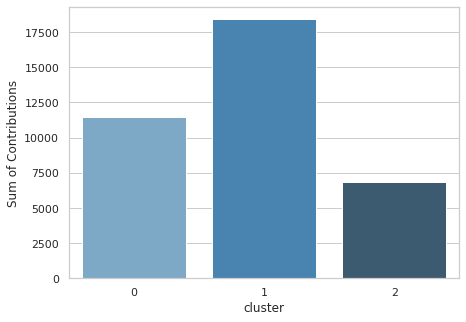

In [95]:
# view average total contributions per ward by cluster
plt.figure(figsize=(7,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Sum of Contributions', data=average_contributions_df, palette="Blues_d")

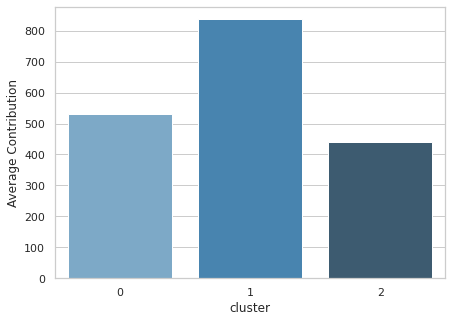

In [96]:
# view average average contribution per ward by cluster
plt.figure(figsize=(7,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Average Contribution', data=average_contributions_df, palette="Blues_d")

Text(0.5, 0, 'Cluster')

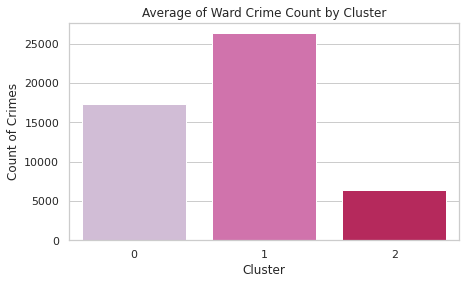

In [97]:
# view average crime per ward by cluster
plt.figure(figsize=(7,4))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Total Count of Crimes', data=average_reduced_df, palette="PuRd")
plt.title('Average of Ward Crime Count by Cluster')
plt.ylabel('Count of Crimes', fontsize=12)
plt.xlabel('Cluster', fontsize=12)

Text(0.5, 0, 'Cluster')

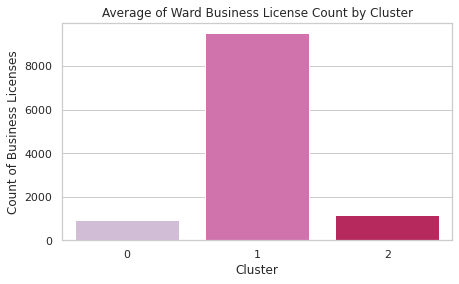

In [98]:
# view average business licenses per ward by cluster
plt.figure(figsize=(7,4))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Total Count of Business Licenses', data=average_reduced_df, palette="PuRd")
plt.title('Average of Ward Business License Count by Cluster')
plt.ylabel('Count of Business Licenses', fontsize=12)
plt.xlabel('Cluster', fontsize=12)

<Figure size 504x288 with 0 Axes>

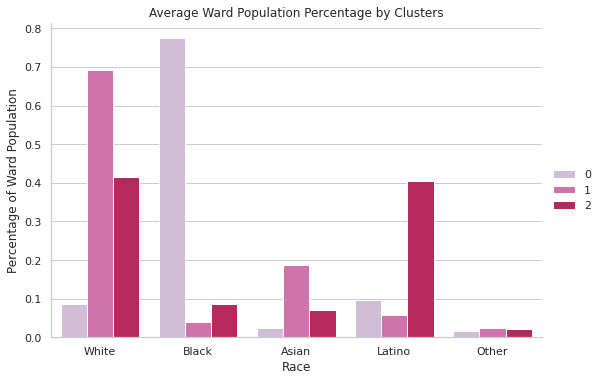

In [99]:
# plot race by cluster
race_df = average_reduced_df.copy()
race_df = race_df[['White2016', 'Black2016', 'Asian2016', 'Latino2016', 'Other2016']]

race_df = race_df.T.unstack().reset_index(level=1, name='Percentage').rename(columns={'level_1':'Race'})[['Race','Percentage']]
race_df.reset_index(inplace=True)
race_df.rename(columns={'index':'Cluster'}, inplace=True)
race_df['Race'] = race_df['Race'].str.slice(0, -4)

# plot
plt.figure(figsize=(7,4))
sns.set_theme(style="whitegrid")
g = sns.catplot(data=race_df, kind="bar", x="Race", y="Percentage", hue="Cluster", palette="PuRd", aspect=1.5)
g.set_axis_labels("Race", "Percentage of Ward Population")
plt.title("Average Ward Population Percentage by Clusters")
g.legend.set_title("")

Text(0.5, 0, 'Cluster')

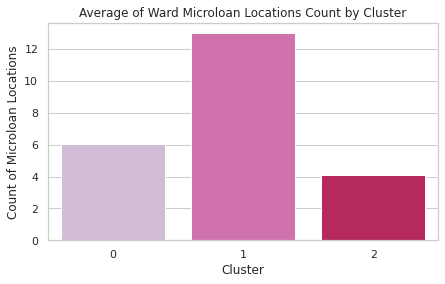

In [100]:
# view average count of microloans per ward by cluster
plt.figure(figsize=(7,4))
sns.set_theme(style="whitegrid")
sns.barplot(x='cluster', y='Total Count of Microlenders', data=average_reduced_df, palette="PuRd")
plt.title('Average of Ward Microloan Locations Count by Cluster')
plt.ylabel('Count of Microloan Locations', fontsize=12)
plt.xlabel('Cluster', fontsize=12)

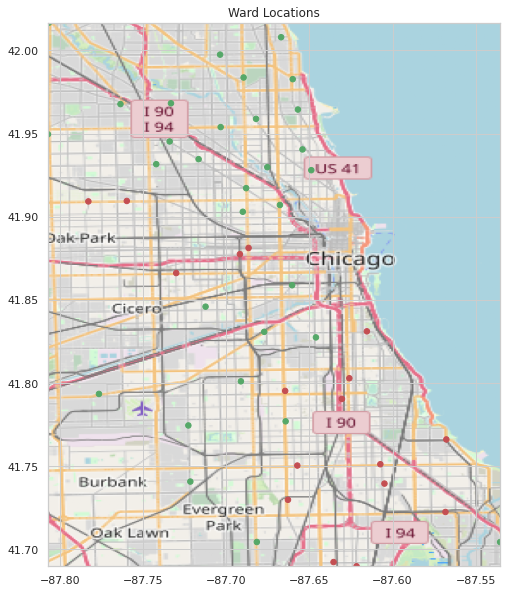

In [101]:
# get ward by cluster
ward_by_cluster = contributions_df[['Ward', 'cluster']]
# get ward location by latitude and longitude
ward_loc = pd.read_csv('/content/drive/MyDrive/M.L. Final Project/Data/Raw Data/Ward_Offices.csv')
ward_loc = ward_loc[['WARD', 'LOCATION']]
ward_loc[['LATITUDE', 'LONGITUDE']] = ward_loc["LOCATION"].str.split(",", n = 1, expand = True)
ward_loc['LATITUDE'] = ward_loc['LATITUDE'].str[1:]
ward_loc['LONGITUDE'] = ward_loc['LONGITUDE'].str[:-1]
ward_loc['LATITUDE'] = ward_loc['LATITUDE'].astype(float)
ward_loc['LONGITUDE'] = ward_loc['LONGITUDE'].astype(float)
# add cluster information to ward location
ward_loc = ward_loc.merge(ward_by_cluster, left_on='WARD', right_on='Ward')
ward_loc.drop(columns=['Ward', 'LOCATION'], inplace=True)
# find bounds
BBox = (ward_loc.LONGITUDE.min(), ward_loc.LONGITUDE.max(), ward_loc.LATITUDE.min(), ward_loc.LATITUDE.max())
# import map of Chicago
ruh_m = plt.imread('/content/drive/MyDrive/M.L. Final Project/Data/chicago_map2.png')
# plot business location
fig, ax = plt.subplots(figsize = (15,10))
categories = np.unique(ward_loc['cluster'])
#colors = np.linspace(0, 1, len(categories))
colors = ['r', 'b', 'g']
colordict = dict(zip(categories, colors))  
ward_loc["Color"] = ward_loc['cluster'].apply(lambda x: colordict[x])
ax.scatter(ward_loc.LONGITUDE, ward_loc.LATITUDE, zorder=1, alpha= 1, c=ward_loc.Color, s=30)
ax.set_title('Ward Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')